In [ ]:
# Step 1: Install gdown if needed
!pip install -q gdown

# Step 2: Download the dataset from Google Drive
!gdown --id 1vC5YVpAaK5QxoZRECKwPrgVQJeIFrQrK --output cross_out_dataset.zip

# Step 3: Unzip it
!unzip -q cross_out_dataset.zip -d cross_out_dataset


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vC5YVpAaK5QxoZRECKwPrgVQJeIFrQrK
From (redirected): https://drive.google.com/uc?id=1vC5YVpAaK5QxoZRECKwPrgVQJeIFrQrK&confirm=t&uuid=377761a7-bb76-4e10-bfff-87b8675a267d
To: /lab2/cross_out_dataset.zip
100%|███████████████████████████████████████| 3.64G/3.64G [00:30<00:00, 121MB/s]
replace cross_out_dataset/cross_out_dataset/train/images/ZIG_ZAG/r02-013-09-01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# ========== Import Libraries ==========
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ========== Custom Dataset Class ==========
class CrossOutBinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Define paths to clean and crossed-out images
        self.clean_dir = os.path.join(root_dir, "CLEAN")
        self.crossed_dir = os.path.join(root_dir, "CROSS")
        self.transform = transform

        self.image_paths = []
        self.labels = []

        # Supported image formats
        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

        # Load all clean images with label 0
        for img_name in os.listdir(self.clean_dir):
            if os.path.splitext(img_name.lower())[1] in valid_extensions:
                self.image_paths.append(os.path.join(self.clean_dir, img_name))
                self.labels.append(0)

        # Load all crossed-out images with label 1
        for img_name in os.listdir(self.crossed_dir):
            if os.path.splitext(img_name.lower())[1] in valid_extensions:
                self.image_paths.append(os.path.join(self.crossed_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image path and label
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image safely
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Failed to open image {image_path}. Error: {e}")
            image = Image.new("RGB", (128, 128))  # Use black fallback image if error

        # Apply transform if defined
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# ========== Transforms / Data Augmentation ==========

# Data augmentation for training data
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),         # Convert to grayscale
    transforms.RandomRotation(degrees=5),                # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small translation
    transforms.Resize((128, 128)),                       # Resize to 128x128
    transforms.ToTensor()                                # Convert to PyTorch tensor
])

# Simple transform for validation and test data (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Backup transform (not used later)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# ========== Dataset Paths ==========
train_path = "/lab2/cross_out_dataset/cross_out_dataset/train/images"
val_path   = "/lab2/cross_out_dataset/cross_out_dataset/val/images"
test_path  = "/lab2/cross_out_dataset/cross_out_dataset/test/images"

# ========== Dataset & Dataloaders ==========
train_dataset = CrossOutBinaryDataset(train_path, transform=train_transform)
val_dataset   = CrossOutBinaryDataset(val_path, transform=val_test_transform)
test_dataset  = CrossOutBinaryDataset(test_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

# ========== Visualize Sample Batch ==========
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i]
    ax.imshow(img.squeeze(0), cmap='gray')  # Display grayscale image
    label = "Crossed-Out" if labels[i].item() == 1 else "Clean"
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

# ========== CNN Model Definition ==========
class CrossOutCNN(nn.Module):
    def __init__(self):
        super(CrossOutCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(128, 1)    # Output layer for binary classification

    def forward(self, x):
        # Pass through conv and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(-1, 32 * 32 * 32)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))  # Output in range [0,1] for binary classification
        return x

# ========== Model Setup ==========
model = CrossOutCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Weight decay for L2 regularization

# ========== Training Function ==========
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Threshold at 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# ========== Start Training ==========
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)


In [29]:
#Save the model
torch.save(model.state_dict(), "crossed_out_classifier.pth")


In [ ]:
##the below section is for manual testing perposes 


In [17]:
import random

random_idx = random.randint(0, len(train_dataset) - 1)
sample_image_path = train_dataset.image_paths[random_idx]
print("Sample Image Path:", sample_image_path)


Sample Image Path: /lab2/cross_out_dataset/cross_out_dataset/train/images/CLEAN/e02-082-07-01.png


In [18]:
from PIL import Image

model.eval()
image_path = "/lab2/cross_out_dataset/cross_out_dataset/train/images/CLEAN/e01-086-01-04.png"  # 👈 use an actual image here
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)
    pred = "Crossed-Out" if output.item() > 0.5 else "Clean"

print(f"Prediction: {pred}")


Prediction: Clean


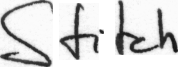

Clean


In [19]:
from IPython.display import display
display(Image.open("/lab2/cross_out_dataset/cross_out_dataset/train/images/CLEAN/e01-086-01-04.png"))
print(pred)  # Model's output


In [20]:
import random

random_idx = random.randint(0, len(train_dataset) - 1)
sample_image_path = train_dataset.image_paths[random_idx]
print("Sample Image Path:", sample_image_path)


Sample Image Path: /lab2/cross_out_dataset/cross_out_dataset/train/images/CLEAN/c06-014-03-01.png


In [21]:
from PIL import Image

model.eval()
image_path = "/lab2/cross_out_dataset/cross_out_dataset/train/images/CROSS/a04-089-07-02.png"  # 👈 use an actual image here
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)
    pred = "Crossed-Out" if output.item() > 0.5 else "Clean"

print(f"Prediction: {pred}")


Prediction: Crossed-Out


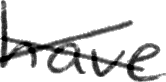

Crossed-Out


In [22]:
from IPython.display import display
display(Image.open("/lab2/cross_out_dataset/cross_out_dataset/train/images/CROSS/a04-089-07-02.png"))
print(pred)  # Model's output


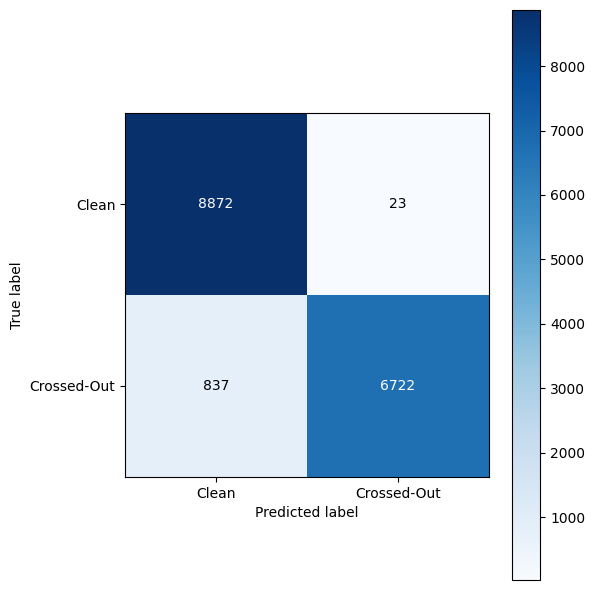

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize empty lists to store true labels and predicted labels
y_true = []
y_pred = []

# Set the model to evaluation mode (disables dropout, etc.)
model.eval()

# Disable gradient computation for evaluation (faster and memory-efficient)
with torch.no_grad():
    # Iterate through the validation data
    for images, labels in val_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)

        # Convert sigmoid outputs to binary (0 or 1) using threshold of 0.5
        preds = (outputs > 0.5).float()

        # Append true and predicted labels to lists (convert to NumPy for sklearn)
        y_true.extend(labels.cpu().numpy())  # Move to CPU, convert to NumPy array
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
# Rows: Actual classes, Columns: Predicted classes
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))  # Create a square plot
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Show matrix as an image
ax.figure.colorbar(im, ax=ax)  # Add colorbar legend

# Define class names for display
classes = ["Clean", "Crossed-Out"]
tick_marks = np.arange(len(classes))

# Set axis labels and ticks
ax.set(xticks=tick_marks, yticks=tick_marks,
       xticklabels=classes, yticklabels=classes,
       ylabel='True label', xlabel='Predicted label')

# Add counts to each cell in the confusion matrix
# Change text color based on the background color for readability
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),  # Print integer value
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Ensure everything fits nicely
plt.tight_layout()
plt.show()


In [25]:
import os

class CrossOutBinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Root directory for images
        self.transform = transform

        self.image_paths = []
        self.labels = []

        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

        # Loop through each subdirectory in the root directory (e.g., SCRATCH, ZIG_ZAG)
        for sub_dir in os.listdir(self.root_dir):
            sub_dir_path = os.path.join(self.root_dir, sub_dir)

            if os.path.isdir(sub_dir_path):
                for img_name in os.listdir(sub_dir_path):
                    if os.path.splitext(img_name.lower())[1] in valid_extensions:
                        self.image_paths.append(os.path.join(sub_dir_path, img_name))
                        
                        # Assign label based on subdirectory name
                        # You can adjust this logic as needed
                        label = 1  # Example: all images in subdirectories are considered crossed-out
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Failed to open image {image_path}. Error: {e}")
            image = Image.new("RGB", (128, 128))  # Fallback: black image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)


Test Accuracy: 67.60%
Time taken for inference: 98.52 seconds


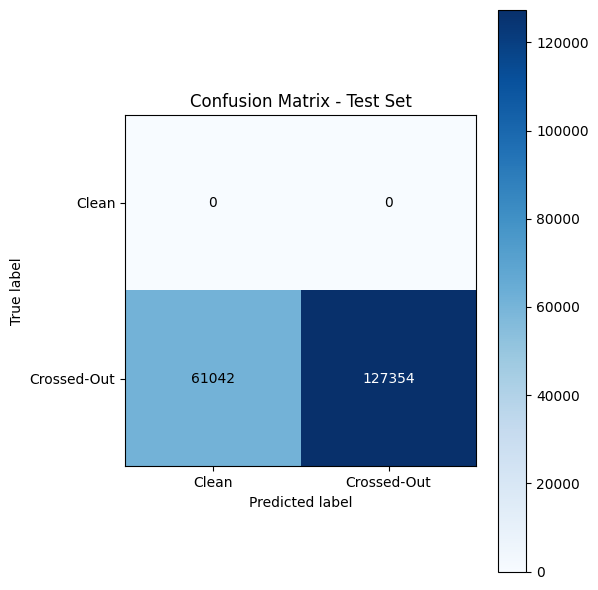

In [31]:
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Start timer to measure inference duration
start_time = time.time()

# Set model to evaluation mode (disables dropout, batchnorm, etc.)
model.eval()

# Counters for accuracy
correct = 0
total = 0

# Lists for collecting true and predicted labels for confusion matrix
y_true = []
y_pred = []

# Disable gradient calculation for efficiency during inference
with torch.no_grad():
    # Iterate over the test dataset
    for images, labels in test_loader:
        # Move inputs and labels to the appropriate device (GPU or CPU)
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        # Get model predictions (sigmoid output)
        outputs = model(images)

        # Convert probabilities to binary predictions (0 or 1)
        preds = (outputs > 0.5).float()

        # Accuracy computation
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Save predictions and true labels for confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute final accuracy
test_accuracy = 100 * correct / total

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Time taken for inference: {processing_time:.2f} seconds")

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
# Compute confusion matrix from collected predictions
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Define class labels
classes = ["Clean", "Crossed-Out"]
tick_marks = np.arange(len(classes))

# Label the axes and ticks
ax.set(xticks=tick_marks, yticks=tick_marks,
       xticklabels=classes, yticklabels=classes,
       ylabel='True label', xlabel='Predicted label',
       title='Confusion Matrix - Test Set')

# Annotate each cell with its value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [ ]:
import os

root_dir = 'cross_out_dataset'  # your main dataset folder

for root, dirs, files in os.walk(root_dir):
    print(f"Current Directory: {root}")
    for dir_name in dirs:
        print(f"  Subfolder: {dir_name}")
    for file_name in files:
        print(f"  File: {file_name}")


In [ ]:
for root, dirs, _ in os.walk('cross_out_dataset'):
    for dir_name in dirs:
        print(os.path.join(root, dir_name))
